In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True, 
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 7708 images belonging to 3 classes.


In [4]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    break

(32, 256, 256, 3)


In [5]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 963 images belonging to 3 classes.


In [6]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 966 images belonging to 3 classes.


In [7]:
7708/32

240.875

In [8]:
963/32

30.09375

In [9]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

cnn_model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    vgg_model,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

In [10]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [11]:
cnn_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_model.trainable = False

In [28]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [36]:
model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation='softmax'))

In [37]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 3)                 771       
                                                                 
Total params: 23,104,323
Trainable params: 8,389,635
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    """
    Learning rate scheduler function that decays the learning rate as the number of epochs increases
    """
    lr = 1e-3
    if epoch > 30:
        lr *= 1e-1
    elif epoch > 20:
        lr *= 5e-1
    elif epoch > 10:
        lr *= 7e-1
    return lr

In [39]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt,  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10)


c:\Users\HP\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=240,
        batch_size=BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=30,
        epochs=EPOCHS,
        callbacks=[lr_scheduler, early_stop]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
240/240 [==============================] - 506s 2s/step - loss: 0.6154 - accuracy: 0.7964 - val_loss: 0.2980 - val_accuracy: 0.8813 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
240/240 [==============================] - 220s 912ms/step - loss: 0.3147 - accuracy: 0.8738 - val_loss: 0.2266 - val_accuracy: 0.8990 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
240/240 [==============================] - 349s 1s/step - loss: 0.2929 - accuracy: 0.8822 - val_loss: 0.1696 - val_accuracy: 0.9521 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
240/240 [==============================] - 130s 541ms/step - loss: 0.2770 - accuracy: 0.8854 - val_loss: 0.1755 - val_accuracy: 0.9312 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
240/240 [=========================

In [42]:
scores = model.evaluate(test_generator)

31/31 [==============================] - 25s 796ms/step - loss: 0.0726 - accuracy: 0.9731


In [43]:
scores

[0.07259818911552429, 0.9730848670005798]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

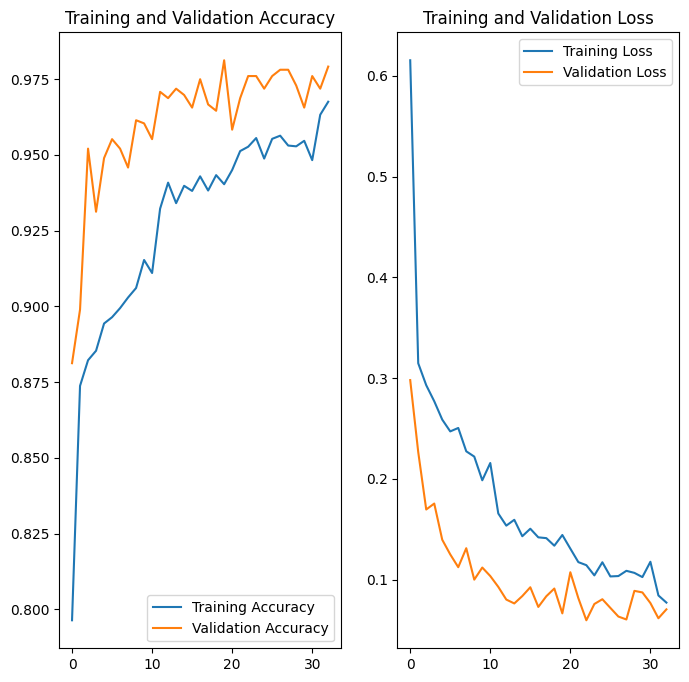

In [50]:
EPOCHS = 33
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
class_names = list(train_generator.class_indices.keys())
class_names

['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']

first image to predict
actual label: Potato_Early_Blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato_Early_Blight


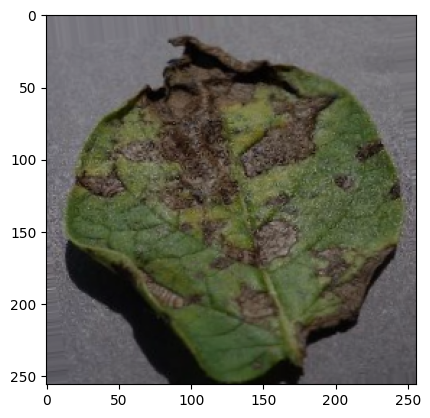

In [52]:
import numpy as np


for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    break

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


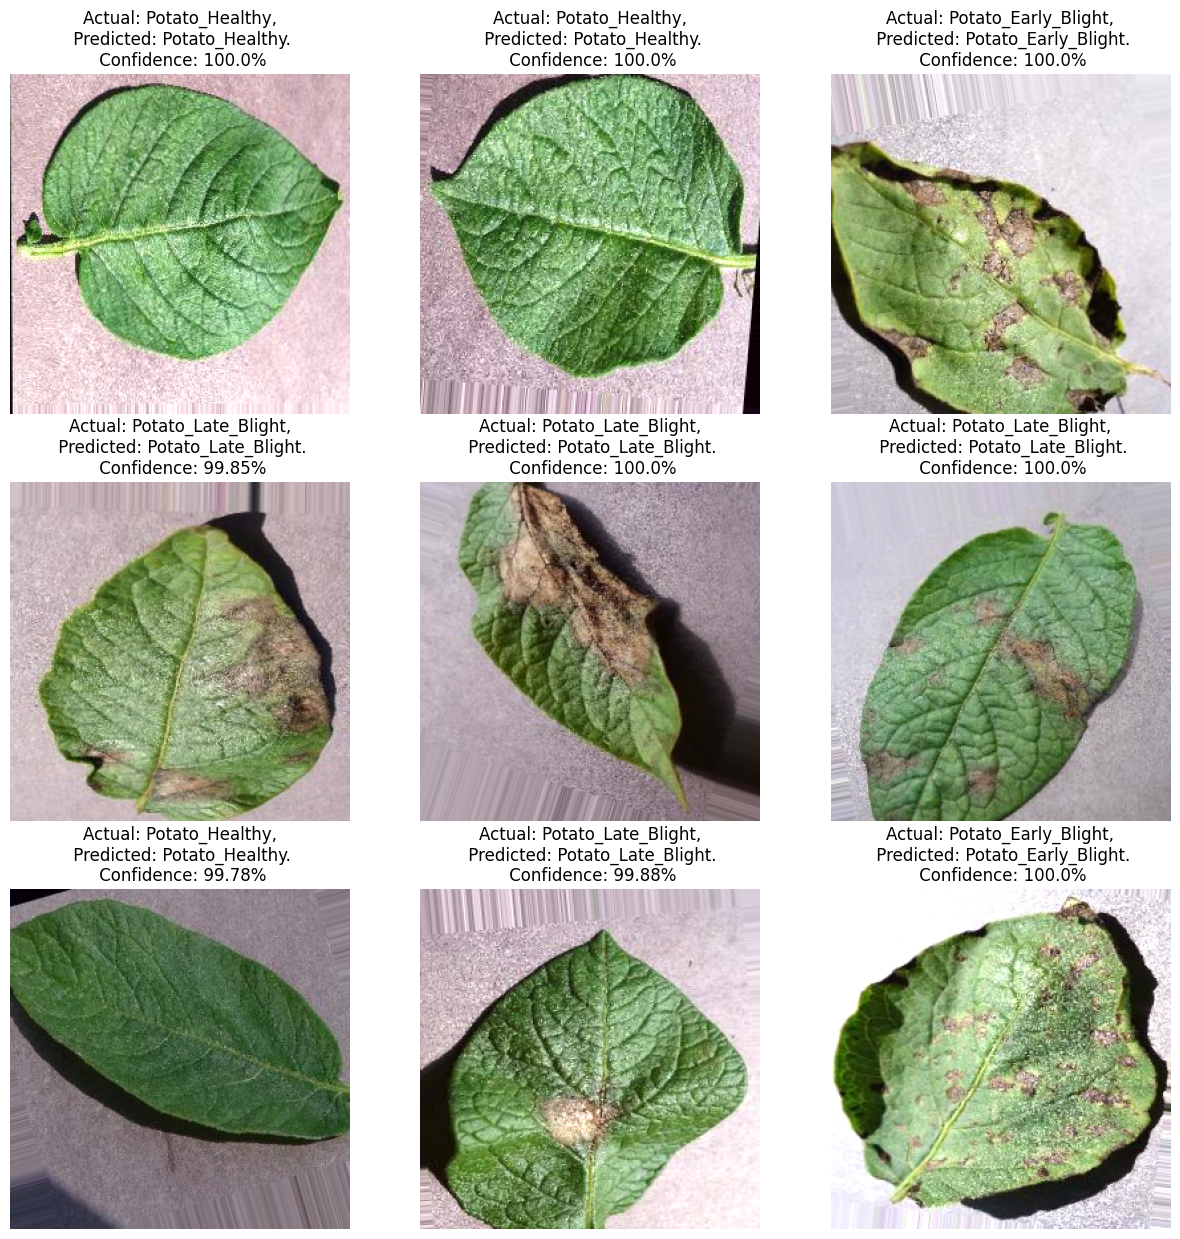

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Load your data and labels
X_train = ...  # your training data
y_train = ...  # your training labels (integer values)

# Convert labels to one-hot encoding
num_classes = 3
y_train = tf.keras.utils.to_categorical(y_train, num_classes)


model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Build the CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the CNN model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

# Load pre-trained VGG16 model and add new layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_model.trainable = False

model = models.Sequential()
model.add(cnn_model)
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16

# Load your data and labels
X_train = ...  # your training data
y_train = ...  # your training labels (integer values)

# Convert labels to one-hot encoding
num_classes = 3
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

# Build the CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the CNN model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

# Load pre-trained VGG16 model and add new layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_model.trainable = False

model = models.Sequential()
model.add(cnn_model)
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)